<a href="https://colab.research.google.com/github/qmeng222/MNIST-Playground/blob/main/autoencoder/tied_weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tied weights** refers to a mirroring or duplication of the weight matrices on the encoder side and the decoder side (imagine a mirror placed in the latent layer).

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib_inline as inl
inl.backend_inline.set_matplotlib_formats("svg")

# An aside on linear class vs parameter matrix:

In [6]:
# 1. parameter matrix:

# create an input and weights matrix
x  = torch.rand(10,50) # torch tensor: 10 data observations, 50 features
W1 = nn.Parameter(torch.randn(128,50)) # NOTE: nn.Parameter expects (output_features,input_features)
print(type(W1)) # torch.nn.Parameter obj, it's a weight matrix!
print(W1.shape)
print(W1, "\n")

# transpose: .T for np arrays, .t() for torch tensors
print(W1.t().shape, "\n")

# compute an output:
y = x@W1.t()
print(y.shape)

<class 'torch.nn.parameter.Parameter'>
torch.Size([128, 50])
Parameter containing:
tensor([[-0.0155,  1.1227,  0.5936,  ...,  1.2316,  0.6162, -0.6362],
        [-0.4457,  1.1612,  0.8343,  ...,  0.4195, -0.8997, -0.1042],
        [ 0.0316,  0.0455, -1.4998,  ...,  0.2317,  1.1810,  0.7898],
        ...,
        [ 1.3243,  0.6907, -0.4463,  ..., -1.1396,  0.2374, -0.4157],
        [ 0.8858,  0.6957,  1.4407,  ..., -0.0844, -0.3703, -1.5666],
        [ 0.1649,  0.4835,  0.9100,  ..., -0.2387,  0.9557,  0.7047]],
       requires_grad=True) 

torch.Size([50, 128]) 

torch.Size([10, 128])


In [22]:
# 2. linear class: x  = torch.rand(10,50)

W2 = nn.Linear(128,50) # NOTE: nn.Linear expects (input_features,output_features)
print(type(W2)) # torch.nn.Lineaer obj, it's NOT simply a weight matrix, it's a class with many atrributes
print(W2)
print("W2:", W2.weight.shape)

# transpose:
W2T = W2.weight.t()
print("W2T:", W2T.shape)

# compute an output:
y = x @ W2.weight
print("inner product:", y.shape)

<class 'torch.nn.modules.linear.Linear'>
Linear(in_features=128, out_features=50, bias=True)
W2: torch.Size([50, 128])
W2T: torch.Size([128, 50])
inner product: torch.Size([10, 128])


In [23]:
# see all attributes of the class Linear:
dir(nn.Linear)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__constants__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_call_impl',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_load_from_state_dict',
 '_maybe_warn_non_full_backward_hook',
 '_named_members',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_version',
 'add_module',
 'apply',
 'bfloat16',
 'buffers',
 'call_super_init',
 'children',
 'cpu',
 'cuda',
 'double',
 'dump_patches',
 'eval',
 'extra_repr',
 'float',
 'forward',
 'get_buffer',
 'get_

# Back to the topic:

In [26]:
# import dataset:
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',') # np array
print(data.shape)

# don't need labels, just extract data:
data   = data[:,1:]

# normalize the data to [0 1]:
dataNorm = data / np.max(data)

# np array -> torch tensor -> float: DL models typically only accept float input data
dataT = torch.tensor( dataNorm ).float()
print(dataT.shape)

(20000, 785)
torch.Size([20000, 784])


In [27]:
def createTheMNISTAE():

  # create a class for the model:
  class aenet(nn.Module):
    def __init__(self):
      super().__init__()

      self.input = nn.Linear(784,128)
      # self.enc = nn.Linear(128,50) # encoder layer: Linear
      self.enc = nn.Parameter(torch.randn(50,128)) # encoder layer: Parameter (output_features, input_features)
      # self.lat = nn.Linear(50,128) # latent layer (not needed here)
      self.dec = nn.Linear(128,784) # decoder layer

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = x.t() # transpose the input matrix
      x = F.relu( self.enc@x ) # NOTE: self.enc is a weight matrix, not a func!
      x = F.relu( self.enc.t()@x ) # same for the decoding layer but reversed
      x = x.t() # and then transpose it back
      y = torch.sigmoid( self.dec(x) ) # get the outputs in the same range as the normalized inputs
      return y

  # create the model instance
  net = aenet()

  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [28]:
# test the model with a bit of data:

net,lossfun,optimizer = createTheMNISTAE()

X = dataT[:5,:]
yHat = net(X)

print(X.shape)
print(yHat.shape)

torch.Size([5, 784])
torch.Size([5, 784])


In [29]:
def function2trainTheModel():

  # create a new model
  net,lossfun,optimizer = createTheMNISTAE()

  numepochs = 10000
  losses = torch.zeros(numepochs)
  for epochi in range(numepochs):

    # select a random set of images
    randomidx = np.random.choice(dataT.shape[0],size=32)
    X = dataT[randomidx,:]

    # forward pass and loss
    yHat = net(X)
    loss = lossfun(yHat,X)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # losses in this epoch
    losses[epochi] = loss.item()
  # end epochs

  # function output
  return losses,net

Final loss: 0.0141


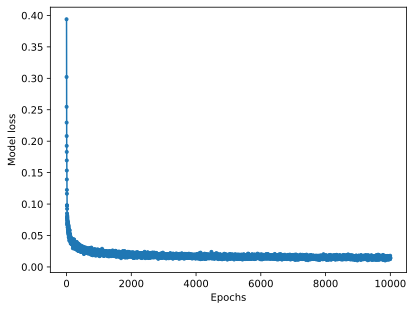

In [30]:
# train the model
losses,net = function2trainTheModel()
print(f'Final loss: {losses[-1]:.4f}')

# visualize the losses
plt.plot(losses,'.-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.show()

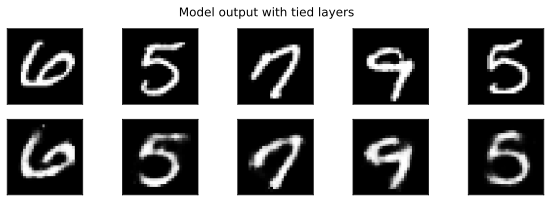

In [31]:
# visualization of inputs and outputs:

X = dataT[:5,:]
yHat = net(X)

fig,axs = plt.subplots(2,5,figsize=(10,3))

for i in range(5):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(yHat[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])

plt.suptitle('Model output with tied layers')
plt.show()

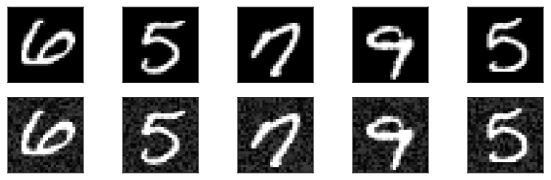

In [32]:
# grab a small set of images
X = dataT[:10,:]

# add noise
Xnoise = X + torch.rand_like(X)/4

# clip at 1
Xnoise[Xnoise>1] = 1

# show the noisy images
fig,axs = plt.subplots(2,5,figsize=(10,3))

for i in range(5):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(Xnoise[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])

plt.show()

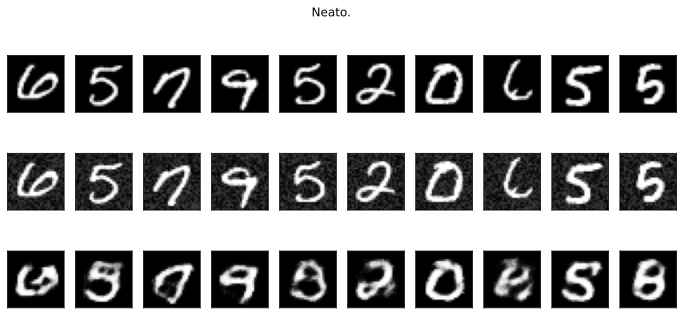

In [33]:
# run through the model
Y = net(Xnoise)

# show the noisy images
fig,axs = plt.subplots(3,10,figsize=(12,5))

for i in range(10):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(Xnoise[i,:].view(28,28).detach() ,cmap='gray')
  axs[2,i].imshow(Y[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  axs[2,i].set_xticks([]), axs[2,i].set_yticks([])

plt.suptitle('Neato.')
plt.show()

👆 Observations and conclusions:
- On one hand, the model did clean up the noise pretty well.
- On the other hand, the noise was sufficiently disruptive to the model that it created some additional distortions (for example, "6" in the above figure).
- **Advantage of tied weights**: fewer model parameters to train -> lower risk of overfitting. Generally comparable performance to non-tied weights.
- **Disadvantage of tied weights**: Performance might be lower. With this particular architecture and this amount of training, tied weights actually didn't really do any favors.